In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [3]:
# df['money'] = df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'] + df['Медиа Диджитал (Моделируемый бренд)_Диджитал, рубли']

# plt.figure(figsize=(45, 15))

# cur_df = df[df.value.notna()]
# plt.plot(cur_df['Период_Начало нед'], cur_df['value'] / cur_df['value'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['money'] / cur_df['money'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['статистика заболеваемости_Статистика заболеваемости'] / cur_df['статистика заболеваемости_Статистика заболеваемости'].max())

# plt.legend(['кол-во продаж', 'кол-во рекламы', 'заболеваемость'])

In [4]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='неделя')
    df['week_sum'] -= df['продажи']
    df['week_count'] -= 1
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['продажи'].shift(1)

    df['feature_EBANIY_RABOTAI'] = df['заболеваемость'].shift(1)

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)

In [5]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [6]:
test_size = 0.2

all_models = []
all_metrics = []
all_preds = []
for i in range(1, 30):
    print(f'Предсказываение на {i} недель вперед')

    cur_df = df[df[f'target_{i}'].notna()]

    if i == 1:
        cur_df = cur_df[(cur_df[f'target_1'] < 1.5) & (cur_df[f'target_1'] > 0.7)]

    train_data, valid_data = cur_df[:int(len(cur_df) * (1-test_size))], cur_df[int(len(cur_df) * (1-test_size)):]

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=2,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',
        custom_metric=['R2'],

        random_state=42,
        thread_count=4
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: 0.0013545	test: -0.0046584	best: -0.0046584 (0)	total: 58.2ms	remaining: 2m 54s
1000:	learn: 0.4341306	test: 0.1721595	best: 0.1729844 (982)	total: 182ms	remaining: 363ms
2000:	learn: 0.5032679	test: 0.1593901	best: 0.1820112 (1171)	total: 285ms	remaining: 142ms
2999:	learn: 0.5376883	test: 0.1627162	best: 0.1820112 (1171)	total: 396ms	remaining: 0us

bestTest = 0.1820111752
bestIteration = 1171

Shrink model to first 1172 iterations.
R2: 0.18201
MAPE: 0.04277

Предсказываение на 2 недель вперед
0:	learn: -0.0168982	test: -0.0067306	best: -0.0067306 (0)	total: 159us	remaining: 479ms
1000:	learn: 0.2218790	test: 0.1948795	best: 0.1948795 (1000)	total: 112ms	remaining: 223ms
2000:	learn: 0.2497148	test: 0.2127027	best: 0.2181105 (1876)	total: 224ms	remaining: 112ms
2999:	learn: 0.2686460	test: 0.2237973	best: 0.2238998 (2988)	total: 332ms	remaining: 0us

bestTest = 0.223899756
bestIteration = 2988

Shrink model to first 2989 iterations.
R2: 0.

In [7]:
with open("models.pkl", "wb") as file:
    pickle.dump(all_models, file)

In [8]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[0].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
0,feature_mean_week,13.283691
3,feature_week,12.373315
2,feature_EBANIY_RABOTAI,11.708137
4,feature_month_diff_1,11.113114
5,feature_month_diff_5,10.333192
10,feature_big_diff_20_weeks,10.150031
8,feature_big_diff_7_weeks,8.282371
1,feature_mean_week_norm,7.350350
7,feature_month_diff_13,6.318391
9,feature_big_diff_13_weeks,6.145206


In [9]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.34518
MAPE: 0.11715


In [10]:
cur_df = df[df[f'target_29'].notna()]

preds = [all_models[i].predict(cur_df[[col for col in cur_df.columns if 'feature' in col]].iloc[[-50]])[0] for i in range(29)]

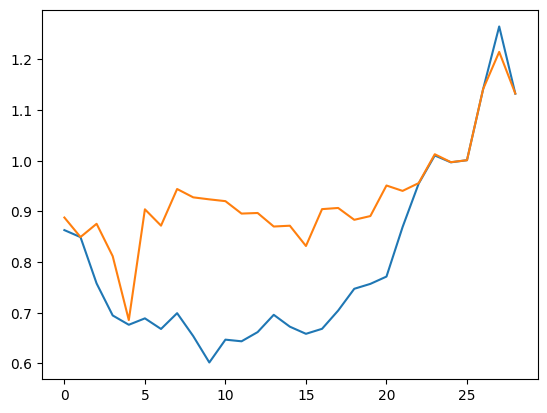

In [11]:
plt.plot([cur_df.iloc[-50][f'target_{i}'] for i in range(1, 30)])
plt.plot(preds)

-----

In [12]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [13]:
all_models = pickle.load(open('models.pkl', 'rb'))

In [14]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [15]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='неделя')
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['продажи'].shift(1)

    df['feature_EBANIY_RABOTAI'] = df['заболеваемость'].shift(1)

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    # bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    # df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.reset_index(drop=True)

In [16]:
max_id = df[df['target_1'].notna()].index.max()

max_id

243

In [17]:
preds = [df.iloc[max_id]['продажи'] * model.predict(df[all_models[0].feature_names_].iloc[max_id+1]) for model in all_models]

sample = pd.DataFrame({
    'week': ['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024'],
    'revenue': preds
})

sample

29

In [18]:
prev = df[df['продажи'].notna()]['продажи'].tolist()[-150:]

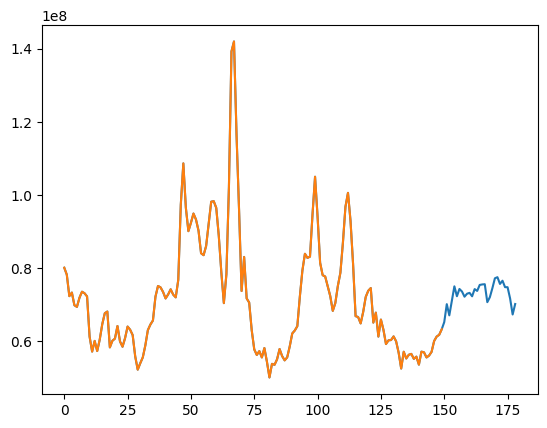

In [19]:
plt.plot(prev + preds)
plt.plot(prev)

In [18]:
print(pd.read_csv('data/sample_submission.csv')['week'].tolist())

['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024']
